# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 0 - Project Overview

### 0.1 - Problem Statement

The goal of this Udacity capstone project is to gain insights to help Starbucks optimize its promotion strategy. Therefore, this project focuses on thoroughly analyzing purchasing decisions and how promotional offers, user behavior, and additional demographic factors influence these decisions.
To do so, I train tree-based regression models to predict a user's profit per offer type and analyze their characteristics to derive recommended actions for Starbucks.

### 0.2 - Metrics Used

The first metric used results from the given problem statement - the profit per user. I am subtracting the sum of all received rewards from the sum of all revenues to obtain the profit per user.

To evaluate the regression models' performance, I use Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). Both MAE and RMSE express average model prediction error in units of the variable of interest and are reliable indicators for a model's predictive performance.

### 0.3 - Project Structure

The notebook is structured as follows:

1. EDA
    - 1.1 - Import libraries
    - 1.2 - Import data
    - 1.3 - Analyze data
<br>    
2. Pre-Processing
    - 2.1 - Rewards
    - 2.2 - Offer Numbers
    - 2.3 - Transaction IDs
    - 2.4 - Comparison of transactions and offer periods
<br>   
3. Feature Engineering
    - 3.1 - Define Target Metric
    - 3.2 - Previous User Behaviour
    - 3.3 - Group by user and offer type
    - 3.4 - Demographics
    - 3.5 - One Hot-Encoding / Scaling
<br>    
4. Modeling
    - 4.1 - Train Tree-Based Regression Models
    - 4.2 - Visualise & Compare Feature Importance
    - 4.3 - Visualise & Compare Error Metrics
    - 4.4 - Hyper-Parameter Tuning
<br>   
5. Evaluation
    - 5.1 - Actual vs. Predicted Profit
    - 5.2 - Shapley Values
<br>    
6. Conclusion & Limitations

# 1 - EDA

### 1.1 - Import libraries

In [2]:
# Utils
import pandas as pd
#pd.options.display.max_rows = 100000
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 100
import numpy as np
import math
import json
import datetime as dt
import importlib
import time
from math import sqrt

# Vis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("BuGn_r")
%matplotlib inline

# ML
from sklearn import preprocessing as p
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.externals import joblib

import shap

# helper files
from src import helpers as h

/Users/gunnargriese/Desktop/python3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### 1.2 - Import data

In [86]:
# Read in json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1.3 - Analyze data

First of all a certain data understanding needs to be obtained before starting with the pre-processing.

### Portfolio data

In [87]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [88]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [89]:
# Visualise distribution of offer types
port_stats = portfolio.groupby("offer_type").agg({"channels": "count",
                                                 "difficulty": "mean",
                                                 "duration": "mean", 
                                                 "reward": "mean"}).reset_index()
port_stats.columns = ["offer_type", "count", "difficulty_mean", "duration_mean", "reward_mean"]

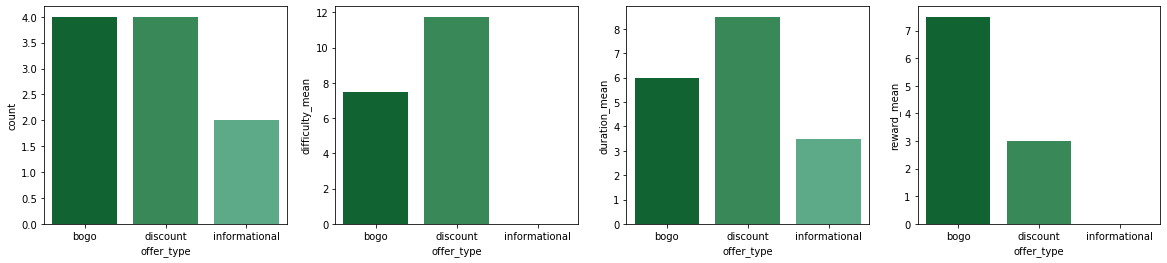

In [90]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
cols = port_stats.columns[1:]

for idx, col in enumerate(port_stats.columns[1:]):
    sns.barplot(data=port_stats, x="offer_type", y=col, ax=ax[idx])

plt.savefig("img/portfolio.png")    

#### Findings:

* There are 10 different offer types: 4x BOGO, 4x Discount, 2x Informational
* On average for discount offers the difficulty as well as the duration is the highest
* Whereas the reward for BOGO offers is on average the highest

### Profile data

In [91]:
# Drop duplicates
profile.drop_duplicates(inplace=True)

In [92]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [93]:
# If age equals 118 it is considered to be a subsitute for NaN. Therefore, I will convert them to NaN.
profile["age"] = profile["age"].apply(lambda x: np.nan if x == 118 else x)

# Furthermore, I will create an additional column that indicates how long a user's profile alread exists (in days).
today = dt.datetime.now()
profile["became_member_on"] = profile["became_member_on"].apply(lambda x: pd.to_datetime(x, format="%Y%m%d"))
profile["member_duration"] = (today - profile["became_member_on"]).dt.days  

In [94]:
# Check for NaNs
profile.isnull().sum()

age                 2175
became_member_on       0
gender              2175
id                     0
income              2175
member_duration        0
dtype: int64

In [95]:
profile.describe()

,age,income,member_duration
count,14825.000000,14825.000000,17000.000000
mean,54.393524,65404.991568,968.449882
std,17.383705,21598.299410,411.223904
min,18.000000,30000.000000,451.000000
25%,42.000000,49000.000000,659.000000
50%,55.000000,64000.000000,809.000000
75%,66.000000,80000.000000,1242.000000
max,101.000000,120000.000000,2274.000000


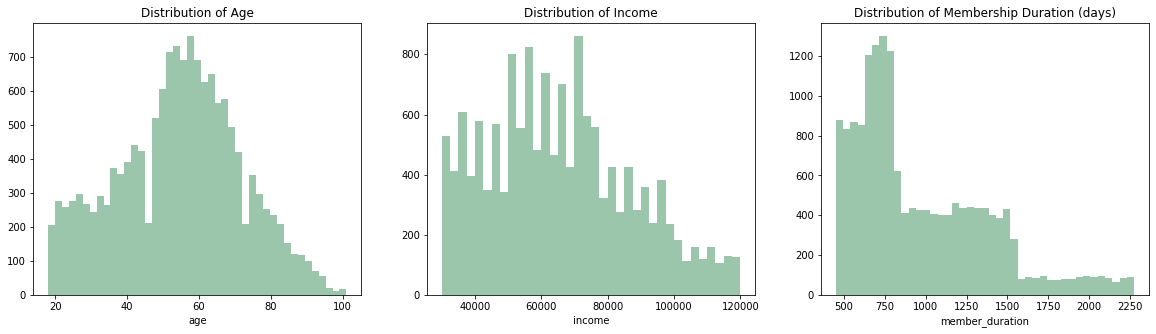

In [96]:
cols = ["age", "income", "member_duration"]

fig, ax = plt.subplots(1, 3, figsize= (20, 5))

for idx, col in enumerate(cols):
    sns.distplot(profile[col].dropna(), hist=True, kde=False, ax=ax[idx])
    
ax[0].set_title("Distribution of Age")
ax[1].set_title("Distribution of Income")
ax[2].set_title("Distribution of Membership Duration (days)")

plt.savefig("img/profile_distplot.png")

#### Findings:

* There are 17,000 user profiles available
* 2,175 (~13%) did not provide any demographic data
* The median age is 55 years
* The median income is 64k USD
* The median membership duration is 805 days. According to the histogram Starbucks was able to increase daily sign ups over time.

### Transcript data

In [ ]:
# Reload helpers file if needed
# importlib.reload(h)

In [97]:
# Unnest transcript data
offer_ids, amounts, rewards = h.unnest_transcripts(transcript["event"], transcript["value"])

In [98]:
# Assign extracted data to new columns
transcript["offer_id"] = offer_ids
transcript["reward"] = rewards
transcript["amount"] = amounts
del transcript["value"]

In [99]:
# Overview
transcript.head(5)

,event,person,time,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [100]:
transcript.drop_duplicates(inplace=True)

In [101]:
# Get descriptive stats for the data
print(transcript.shape)
transcript.describe()

(306137, 6)


,time,reward,amount
count,306137.000000,33182.000000,138953.000000
mean,366.185015,4.902628,12.777356
std,200.348174,2.887201,30.250529
min,0.000000,2.000000,0.050000
25%,186.000000,2.000000,2.780000
50%,408.000000,5.000000,8.890000
75%,528.000000,5.000000,18.070000
max,714.000000,10.000000,1062.280000


In [102]:
trans_data = transcript.groupby(["event", "time"]).size().reset_index()
trans_data.columns = ["event", "time", "count"]
trans_data.head()

,event,time,count
0,offer completed,0,206
1,offer completed,6,276
2,offer completed,12,280
3,offer completed,18,252
4,offer completed,24,265


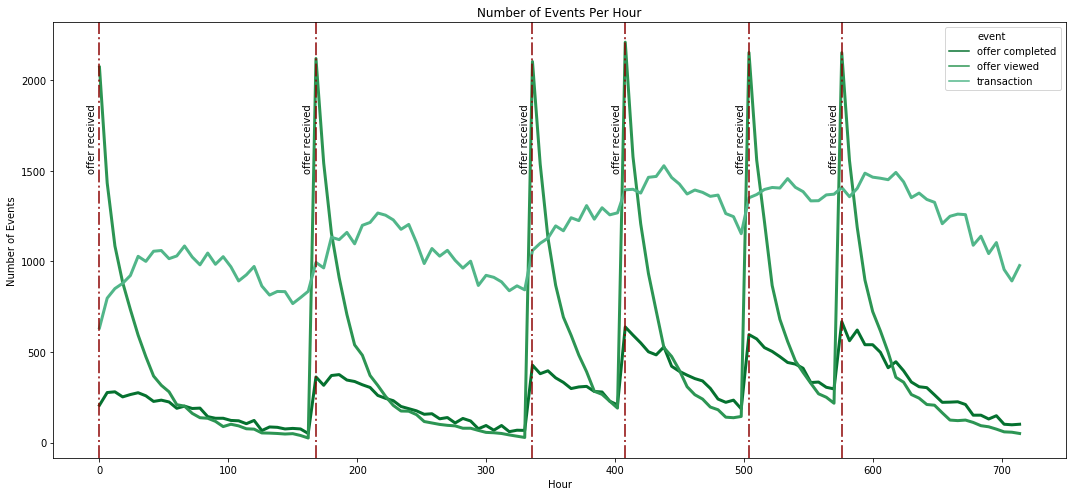

In [103]:
# Set plot size
fig, ax = plt.subplots(1,1, figsize = (15,7))

# Plot time series of offer events (excluding 'offer received')
ax = sns.lineplot(x="time", y="count", hue="event", data=trans_data[(trans_data["event"] == "transaction") |
                                                                    (trans_data["event"] == "offer viewed") |
                                                                    (trans_data["event"] == "offer completed")], linewidth=3.)

# Plot lines for days of offer sendout
for time in trans_data[trans_data["event"] == "offer received"]["time"]:
    plt.axvline(x=time, linestyle="dashdot", linewidth=2., alpha=0.75, color="darkred")
    plt.text(time-10, 1500, "offer received", rotation=90)
    plt.tight_layout()
    
# Label plot
ax.set_ylabel('Number of Events')
ax.set_xlabel('Hour')
ax.set_title('Number of Events Per Hour')
plt.tight_layout()
plt.savefig("img/events_over_time.png")

#### Findings

* Starbucks sent out 6 distinct offers
* Most of the offers are viewed and completed on the same day as they were sent out
* Transaction peaks are slightly delayed
* Higher frequency of offers seems to increase overall transaction level

# 2 - Pre-Processing

#### Approach:

1. Create a data frame showing the rewards per user as well as the according timestamp.
2. Add offer numbers to transcript data in order to see, if a user has seen the same offer more than once.
3. Add transaction IDs to be able to distinguish between distinct transactions.
4. Identify events that were under the influence of an specific offer.
5. Identify transactions that occured under the influence of an offer.
6. Reshape data so the relevant information is available on transaction level.

### 2.1 - Rewards

In [104]:
# Calculate rewards per user per timestamp
rel_cols = ["person", "time", "reward"]
reward_df = transcript[transcript["event"]=="offer completed"][rel_cols]
reward_df = reward_df.groupby(["person", "time"]).agg({"reward": "sum"}).reset_index()
reward_df.head()

,person,time,reward
0,0009655768c64bdeb2e877511632db8f,414,5.0
1,0009655768c64bdeb2e877511632db8f,528,2.0
2,0009655768c64bdeb2e877511632db8f,576,2.0
3,0011e0d4e6b944f998e987f904e8c1e5,252,3.0
4,0011e0d4e6b944f998e987f904e8c1e5,576,10.0


### 2.2 - Offer Numbers

In [105]:
# Mark events where a user received an offer
transcript["received_offer"] = transcript["event"].apply(lambda x: 1 if x == "offer received" else np.nan)

# Count how many times a user received a specific offer
transcript["offer_count"] = transcript.groupby(["person", "offer_id", "received_offer"]).cumcount()+1

# Only keep the counts for the "offer received" events
new_offer_count = []
for event, offer_count in zip(transcript.event, transcript.offer_count):
    if event != "offer received":
        new_offer_count.append(np.nan)
    else:
        new_offer_count.append(offer_count)
        
transcript["offer_count"] = new_offer_count

# Assign all events under the influence of an offer to that specific offer
transcript["offer_count"] = transcript.groupby(["person", "offer_id"])["offer_count"].apply(lambda x: x.ffill())
del transcript["received_offer"]
transcript.head()

,event,person,time,offer_id,reward,amount,offer_count
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,1.0


### 2.3 - Transaction IDs

In [106]:
# Assign indexes as unique transaction ids
transcript["trans_id"] = np.where(transcript['event'] == 'transaction', transcript.index.values, np.nan)

In [107]:
# Validation
transcript[transcript["person"]=="0009655768c64bdeb2e877511632db8f"]

,event,person,time,offer_id,reward,amount,offer_count,trans_id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,1.0,NaN
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,1.0,NaN
89291,transaction,0009655768c64bdeb2e877511632db8f,228,NaN,NaN,22.16,NaN,89291.0
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,1.0,NaN
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,1.0,NaN
153401,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,1.0,NaN
168412,transaction,0009655768c64bdeb2e877511632db8f,414,NaN,NaN,8.57,NaN,168412.0
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,1.0,NaN
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,1.0,NaN
204340,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,1.0,NaN


### 2.4 - Compare transactions with offer periods

First, isolation of all "transaction" events is required.

In [108]:
trans = transcript[transcript["event"]=="transaction"].drop(["offer_id", "offer_count", "reward"], axis = 1)
trans = trans.merge(reward_df, on=["person", "time"], how="left")
trans["reward"].fillna(0, inplace=True)

In [109]:
trans.head()

,event,person,time,amount,trans_id,reward
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,12654.0,0.0
1,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,12657.0,2.0
2,transaction,54890f68699049c2a04d415abc25e717,0,13.23,12659.0,0.0
3,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,12670.0,0.0
4,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,12671.0,2.0


In [110]:
# Validation
trans[trans["person"]=="0009655768c64bdeb2e877511632db8f"]

,event,person,time,amount,trans_id,reward
37632,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,89291.0,0.0
71464,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,168412.0,5.0
97672,transaction,0009655768c64bdeb2e877511632db8f,528,14.11,228422.0,2.0
103292,transaction,0009655768c64bdeb2e877511632db8f,552,13.56,237784.0,0.0
108756,transaction,0009655768c64bdeb2e877511632db8f,576,10.27,258883.0,2.0
128288,transaction,0009655768c64bdeb2e877511632db8f,660,12.36,293497.0,0.0
134218,transaction,0009655768c64bdeb2e877511632db8f,690,28.16,300930.0,0.0
135267,transaction,0009655768c64bdeb2e877511632db8f,696,18.41,302205.0,0.0


In [111]:
# Pivot table
offer_df = transcript.pivot_table(index=["person", "offer_id", "offer_count"], columns="event", values="time").reset_index()

# Rename columns
offer_df.columns = ["person", "offer_id", "offer_count", "hour_completed", "hour_received", "hour_viewed"]
offer_df.index.name = None

# Add information on offers from portfolio table
offer_df = offer_df.merge(portfolio[["id", "duration"]], 
                          left_on="offer_id", right_on="id", how="left")

# Calculate max. offer duration for distinct offers
offer_df["hour_expired"] = offer_df["hour_received"] + (offer_df["duration"] * 24)

# Defining the end of an offer period (user either completes the offer or the offer expires due to max. duration)
offer_df["hour_ended"] = np.where(offer_df["hour_completed"].isna(), offer_df["hour_expired"], offer_df["hour_completed"])

offer_df.drop(["id", "duration", "hour_expired"], axis=1, inplace=True)

In [112]:
offer_df.head()

,person,offer_id,offer_count,hour_completed,hour_received,hour_viewed,hour_ended
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,576.0,576.0,NaN,576.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,NaN,336.0,372.0,432.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,NaN,168.0,192.0,240.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,414.0,408.0,456.0,414.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,528.0,504.0,540.0,528.0


In [113]:
# Join offers and transaction data
tmp = trans.merge(offer_df, on="person", how="left")

# Check if a transaction was actually under the influence of an offer
times, viewed, ended, offer_ids = tmp["time"], tmp["hour_viewed"], tmp["hour_ended"], tmp["offer_id"]
new_offer_ids = []
for time, view, end, offer_id in zip(times, viewed, ended, offer_ids):
    if time >= view and time <= end:
        new_offer_ids.append(offer_id)
    else:
        new_offer_ids.append(np.nan)

tmp["offer_id"] = new_offer_ids
tmp["offer_id"].fillna(0, inplace=True)

# Flag transactions that were influenced by offers
tmp["offer_response"] = tmp["offer_id"].apply(lambda x: np.nan if x==0 else 1)

# Add offer meta data
tmp = tmp.merge(portfolio[["id", "offer_type", "difficulty", "reward"]], how="left", left_on="offer_id", right_on="id")
tmp = tmp.rename(columns = {"reward_x": "received_reward",
                        "reward_y": "expected_reward"})

# Fill NaN values
tmp["difficulty"].fillna(0, inplace=True)
tmp["expected_reward"].fillna(0, inplace=True)
tmp["offer_type"].fillna("none", inplace=True)

# Drop useless columns
tmp.drop(["event", "offer_count", "hour_completed", "hour_received", "hour_viewed", "hour_ended", "id"], axis=1, inplace=True)

In [115]:
# Validation
tmp[tmp["person"]=="0009655768c64bdeb2e877511632db8f"]

,person,time,amount,trans_id,received_reward,offer_id,offer_response,offer_type,difficulty,expected_reward
173430,0009655768c64bdeb2e877511632db8f,228,22.16,89291.0,0.0,0,NaN,none,0.0,0.0
173431,0009655768c64bdeb2e877511632db8f,228,22.16,89291.0,0.0,0,NaN,none,0.0,0.0
173432,0009655768c64bdeb2e877511632db8f,228,22.16,89291.0,0.0,5a8bc65990b245e5a138643cd4eb9837,1.0,informational,0.0,0.0
173433,0009655768c64bdeb2e877511632db8f,228,22.16,89291.0,0.0,0,NaN,none,0.0,0.0
173434,0009655768c64bdeb2e877511632db8f,228,22.16,89291.0,0.0,0,NaN,none,0.0,0.0
329361,0009655768c64bdeb2e877511632db8f,414,8.57,168412.0,5.0,0,NaN,none,0.0,0.0
329362,0009655768c64bdeb2e877511632db8f,414,8.57,168412.0,5.0,3f207df678b143eea3cee63160fa8bed,1.0,informational,0.0,0.0
329363,0009655768c64bdeb2e877511632db8f,414,8.57,168412.0,5.0,0,NaN,none,0.0,0.0
329364,0009655768c64bdeb2e877511632db8f,414,8.57,168412.0,5.0,0,NaN,none,0.0,0.0
329365,0009655768c64bdeb2e877511632db8f,414,8.57,168412.0,5.0,0,NaN,none,0.0,0.0


In [116]:
# Use the following columns as index for pivoting
idx = ["person", "time", "trans_id", "amount", "received_reward"]

# Reshape the data frame
tmp_types = tmp.drop("offer_id", axis=1).pivot_table(index=idx, columns=["offer_type"], aggfunc=np.sum).reset_index()

# Rename columns
tmp_types.columns = ['person','time','trans_id','amount','received_reward',
               'difficulty_bogo','difficulty_discount','difficulty_informational', 'difficulty_none',
               'reward_expected_bogo','reward_expected_discount','reward_expected_informational', 'reward_expected_none',
               'bogo_tally','discount_tally','informational_tally', 'none_tally']

# Drop irrelevant columns
tmp_types.drop(['difficulty_none', 'reward_expected_none', 'none_tally'], axis=1, inplace=True)

# Sum difficulties and rewards per offer 
tmp_types["difficulty"] = tmp_types["difficulty_bogo"] + tmp_types["difficulty_discount"] + tmp_types["difficulty_informational"]
tmp_types["reward_expected"] = tmp_types["reward_expected_bogo"] + tmp_types["reward_expected_discount"] + tmp_types["reward_expected_informational"]

# Drop irrelevant columns and rename remaining (add aliases for for offer numbers for better readibility)
drop_cols = ["difficulty_bogo", "difficulty_discount", "difficulty_informational",
            "reward_expected_bogo", "reward_expected_discount", "reward_expected_informational"]

tmp_types.drop(drop_cols, axis=1, inplace=True)

tmp_ids = tmp.drop(["offer_type", "difficulty", "expected_reward"], axis=1).pivot_table(index=idx, columns="offer_id", aggfunc=np.sum).reset_index()
tmp_ids.drop(("offer_response", 0), axis=1, inplace=True)

# Rename columns and assign aliases to offer ids for increased readibility
tmp_ids.columns = ["person", "time", "trans_id", "amount", "received_reward",
                   "tally_offer_1", # 0b1e1539f2cc45b7b9fa7c272da2e1d7
                   "tally_offer_2", # 2298d6c36e964ae4a3e7e9706d1fb8c2
                   "tally_offer_3", # 2906b810c7d4411798c6938adc9daaa5
                   "tally_offer_4", # 3f207df678b143eea3cee63160fa8bed
                   "tally_offer_5", # 4d5c57ea9a6940dd891ad53e9dbe8da0
                   "tally_offer_6", # 5a8bc65990b245e5a138643cd4eb9837
                   "tally_offer_7", # 9b98b8c7a33c4b65b9aebfe6a799e6d9
                   "tally_offer_8", # ae264e3637204a6fb9bb56bc8210ddfd
                   "tally_offer_9", # f19421c1d4aa40978ebb69ca19b0e20d
                   "tally_offer_10" # fafdcd668e3743c1bb461111dcafc2a4
                  ]

# Merge the two resulting data frames and fill nans
tmp_final = tmp_types.merge(tmp_ids, on=["person", "time", "trans_id", "amount", "received_reward"], how="left")
tmp_final.drop("trans_id", axis=1, inplace=True)
tmp_final.fillna(0, inplace=True)

# Turn the offer count columns into binary columns (since users rarely see one offer two times)
binary_cols = ["tally_offer_1", "tally_offer_2", "tally_offer_3", "tally_offer_4", "tally_offer_5", 
               "tally_offer_6", "tally_offer_7", "tally_offer_8", "tally_offer_9", "tally_offer_10",
               "bogo_tally","discount_tally", "informational_tally"]

for col in binary_cols:
    tmp_final[col] = tmp_final[col].apply(lambda x: 1 if x > 1 else x)

In [117]:
# Validation
tmp_final[tmp_final["person"]=="0009655768c64bdeb2e877511632db8f"]

,person,time,amount,received_reward,bogo_tally,discount_tally,informational_tally,difficulty,reward_expected,tally_offer_1,tally_offer_2,tally_offer_3,tally_offer_4,tally_offer_5,tally_offer_6,tally_offer_7,tally_offer_8,tally_offer_9,tally_offer_10
0,0009655768c64bdeb2e877511632db8f,228,22.16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,414,8.57,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,528,14.11,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,552,13.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,576,10.27,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0009655768c64bdeb2e877511632db8f,660,12.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0009655768c64bdeb2e877511632db8f,690,28.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0009655768c64bdeb2e877511632db8f,696,18.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
tmp_final.shape

(138953, 19)

### 2.5 - Save resulting data frames

In [ ]:
# Save results to prevent re-running all the pre-processing steps later on
tmp_final.to_csv("data/transactions_final.csv")
transcript.to_csv("data/transcript_final.csv")
reward_df.to_csv("data/rewards_final.csv")
offer_df.to_csv("data/offers_final.csv")
portfolio.to_csv("data/portfolio_final.csv")
profile.to_csv("data/profile_final.csv")

In [3]:
# Load data
transactions = pd.read_csv("data/transactions_final.csv", index_col=0)
transcript = pd.read_csv("data/transcript_final.csv")
reward_df = pd.read_csv("data/rewards_final.csv")
offer_df = pd.read_csv("data/offers_final.csv")
portfolio = pd.read_csv("data/portfolio_final.csv")
profile = pd.read_csv("data/profile_final.csv")

# 3 - Feature Engineering

#### Approach:

1. Add target metric for modeling - profit.
2. Calculate previous user behaviour.
3. Group profit per user per offer type.
4. Add demographic user information as additional features.
5. Prepare features for applying ML (one hot-encoding / scaling).

### 3.1 - Target Metric

In [4]:
transactions["profit"] = transactions["amount"] - transactions["received_reward"]

### 3.2 - Previous User Behaviour

In [5]:
# Calculate how many times a user was exposed to offers before the current transaction
cumsum_cols = ['amount', 'received_reward', 'bogo_tally', 'discount_tally', 'informational_tally']

for col in cumsum_cols:
    new_col = "hist_" + col
    transactions[new_col] = transactions.sort_values(by="time", ascending=True).groupby("person")[col].cumsum()
    transactions[new_col] = transactions[new_col] - transactions[col]
    
hist_cols = ["hist_bogo_tally", "hist_discount_tally", "hist_informational_tally"]

for col in hist_cols:
    transactions[col] = transactions[col].apply(lambda x: 1 if x > 1 else x)

# Calculate time diff to previous transaction
transactions["prev_trans"] = transactions.sort_values(by="time", ascending=True).groupby("person")["time"].shift(1)
transactions["time_diff"] = transactions["time"] - transactions["prev_trans"]
transactions = transactions[transactions["time_diff"].notnull()]

del transactions["prev_trans"]

# Validation
transactions[transactions["person"]=="0009655768c64bdeb2e877511632db8f"]

,person,time,amount,received_reward,bogo_tally,discount_tally,informational_tally,difficulty,reward_expected,tally_offer_1,tally_offer_2,tally_offer_3,tally_offer_4,tally_offer_5,tally_offer_6,tally_offer_7,tally_offer_8,tally_offer_9,tally_offer_10,profit,hist_amount,hist_received_reward,hist_bogo_tally,hist_discount_tally,hist_informational_tally,time_diff
1,0009655768c64bdeb2e877511632db8f,414,8.57,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.57,22.16,0.0,0.0,0.0,1.0,186.0
2,0009655768c64bdeb2e877511632db8f,528,14.11,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.11,30.73,5.0,0.0,0.0,1.0,114.0
3,0009655768c64bdeb2e877511632db8f,552,13.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.56,44.84,7.0,0.0,0.0,1.0,24.0
4,0009655768c64bdeb2e877511632db8f,576,10.27,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.27,58.40,7.0,0.0,0.0,1.0,24.0
5,0009655768c64bdeb2e877511632db8f,660,12.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.36,68.67,9.0,0.0,0.0,1.0,84.0
6,0009655768c64bdeb2e877511632db8f,690,28.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.16,81.03,9.0,0.0,0.0,1.0,30.0
7,0009655768c64bdeb2e877511632db8f,696,18.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.41,109.19,9.0,0.0,0.0,1.0,6.0


### 3.3 - Group by user and offer type level

In order to later analyze a users response to specific offer types the information gets grouped accordingly.

In [6]:
# Define columns for grouping
groups = ['person','bogo_tally','discount_tally','informational_tally']

# Apply grouping
transactions = pd.DataFrame(transactions.groupby(groups, as_index=False).mean())

# Should be fewer rows now (one for each user/offer type combination)
print(transactions.shape)
transactions.head()

(39297, 26)


,person,bogo_tally,discount_tally,informational_tally,time,amount,received_reward,difficulty,reward_expected,tally_offer_1,tally_offer_2,tally_offer_3,tally_offer_4,tally_offer_5,tally_offer_6,tally_offer_7,tally_offer_8,tally_offer_9,tally_offer_10,profit,hist_amount,hist_received_reward,hist_bogo_tally,hist_discount_tally,hist_informational_tally,time_diff
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,0.0,617.0,16.145,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.478333,65.476667,7.666667,0.0,0.0,1.0,47.0
1,0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,414.0,8.570,5.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.570000,22.160000,0.000000,0.0,0.0,1.0,186.0
2,00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,0.0,465.0,1.695,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.695000,0.800000,0.000000,0.0,0.0,0.0,90.0
3,0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,0.0,648.0,15.995,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.995000,58.985000,13.000000,1.0,1.0,0.0,39.0
4,0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,0.0,252.0,11.930,3.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.930000,13.490000,0.000000,0.0,0.0,0.0,120.0


### 3.4 - Demographics

In [7]:
# Add demographic data to transactions
transactions = transactions.merge(profile[["id", "age", "gender", "income", "member_duration"]], how="left", left_on="person", right_on="id")

In [8]:
# Impute NaN values with median
transactions['age'] = transactions['age'].fillna(transactions['age'].median())
transactions['income'] = transactions['income'].fillna(transactions['income'].median())

# Create buckets for features
transactions['age_bucket'] = pd.qcut(transactions['age'], q=4)
transactions['income_bucket'] = pd.qcut(transactions['income'], q=4)
transactions['member_duration_bucket'] = pd.qcut(transactions['member_duration'], q=4)

In [9]:
# Validation
transactions[transactions["person"]=="0009655768c64bdeb2e877511632db8f"]

,person,bogo_tally,discount_tally,informational_tally,time,amount,received_reward,difficulty,reward_expected,tally_offer_1,tally_offer_2,tally_offer_3,tally_offer_4,tally_offer_5,tally_offer_6,tally_offer_7,tally_offer_8,tally_offer_9,tally_offer_10,profit,hist_amount,hist_received_reward,hist_bogo_tally,hist_discount_tally,hist_informational_tally,time_diff,id,age,gender,income,member_duration,age_bucket,income_bucket,member_duration_bucket
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,0.0,617.0,16.145,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.478333,65.476667,7.666667,0.0,0.0,1.0,47.0,0009655768c64bdeb2e877511632db8f,33.0,M,72000.0,908,"(17.999, 44.0]","(62000.0, 74000.0]","(900.0, 1296.0]"
1,0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,414.0,8.570,5.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.570000,22.160000,0.000000,0.0,0.0,1.0,186.0,0009655768c64bdeb2e877511632db8f,33.0,M,72000.0,908,"(17.999, 44.0]","(62000.0, 74000.0]","(900.0, 1296.0]"


### 3.5 - One Hot-Encoding / Scaling

In [10]:
# Get rid of unnecessary columns
data = transactions.drop(labels=["person", "time", "id", "amount", "age", "income", "member_duration"], axis=1)

In [11]:
# One hot encoding of categorical features
data = pd.get_dummies(data, columns=["age_bucket", "income_bucket", "member_duration_bucket", "gender"])
data.head()

,bogo_tally,discount_tally,informational_tally,received_reward,difficulty,reward_expected,tally_offer_1,tally_offer_2,tally_offer_3,tally_offer_4,tally_offer_5,tally_offer_6,tally_offer_7,tally_offer_8,tally_offer_9,tally_offer_10,profit,hist_amount,hist_received_reward,hist_bogo_tally,hist_discount_tally,hist_informational_tally,time_diff,"age_bucket_(17.999, 44.0]","age_bucket_(44.0, 55.0]","age_bucket_(55.0, 64.0]","age_bucket_(64.0, 101.0]","income_bucket_(29999.999, 50000.0]","income_bucket_(50000.0, 62000.0]","income_bucket_(62000.0, 74000.0]","income_bucket_(74000.0, 120000.0]","member_duration_bucket_(446.999, 683.0]","member_duration_bucket_(683.0, 900.0]","member_duration_bucket_(900.0, 1296.0]","member_duration_bucket_(1296.0, 2270.0]",gender_F,gender_M,gender_O
0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.478333,65.476667,7.666667,0.0,0.0,1.0,47.0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,0.0,0.0,1.0,5.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.570000,22.160000,0.000000,0.0,0.0,1.0,186.0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.695000,0.800000,0.000000,0.0,0.0,0.0,90.0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.995000,58.985000,13.000000,1.0,1.0,0.0,39.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
4,0.0,1.0,0.0,3.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.930000,13.490000,0.000000,0.0,0.0,0.0,120.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1


In [12]:
# Create a copy of the dataframe
scaled_features = data.copy()

# Apply scaler to continuous features
col_names = ["received_reward", "difficulty", "reward_expected", "hist_amount", "hist_received_reward", "time_diff"]

features = scaled_features[col_names]
scaler = p.MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

# Re-assign columns
scaled_features[col_names] = features

data = scaled_features

In [13]:
print(data.shape)
data.head()

(39297, 38)


,bogo_tally,discount_tally,informational_tally,received_reward,difficulty,reward_expected,tally_offer_1,tally_offer_2,tally_offer_3,tally_offer_4,tally_offer_5,tally_offer_6,tally_offer_7,tally_offer_8,tally_offer_9,tally_offer_10,profit,hist_amount,hist_received_reward,hist_bogo_tally,hist_discount_tally,hist_informational_tally,time_diff,"age_bucket_(17.999, 44.0]","age_bucket_(44.0, 55.0]","age_bucket_(55.0, 64.0]","age_bucket_(64.0, 101.0]","income_bucket_(29999.999, 50000.0]","income_bucket_(50000.0, 62000.0]","income_bucket_(62000.0, 74000.0]","income_bucket_(74000.0, 120000.0]","member_duration_bucket_(446.999, 683.0]","member_duration_bucket_(683.0, 900.0]","member_duration_bucket_(900.0, 1296.0]","member_duration_bucket_(1296.0, 2270.0]",gender_F,gender_M,gender_O
0,0.0,0.0,0.0,0.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.478333,0.050753,0.178295,0.0,0.0,1.0,0.061012,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,0.0,0.0,1.0,0.227273,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.570000,0.017151,0.000000,0.0,0.0,1.0,0.267857,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.695000,0.000582,0.000000,0.0,0.0,0.0,0.125000,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.995000,0.045717,0.302326,1.0,1.0,0.0,0.049107,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
4,0.0,1.0,0.0,0.136364,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.930000,0.010426,0.000000,0.0,0.0,0.0,0.169643,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1


### 3.6 - Correlation Matrix

Calculate the correlation coefficients between dependent and all independent variables.

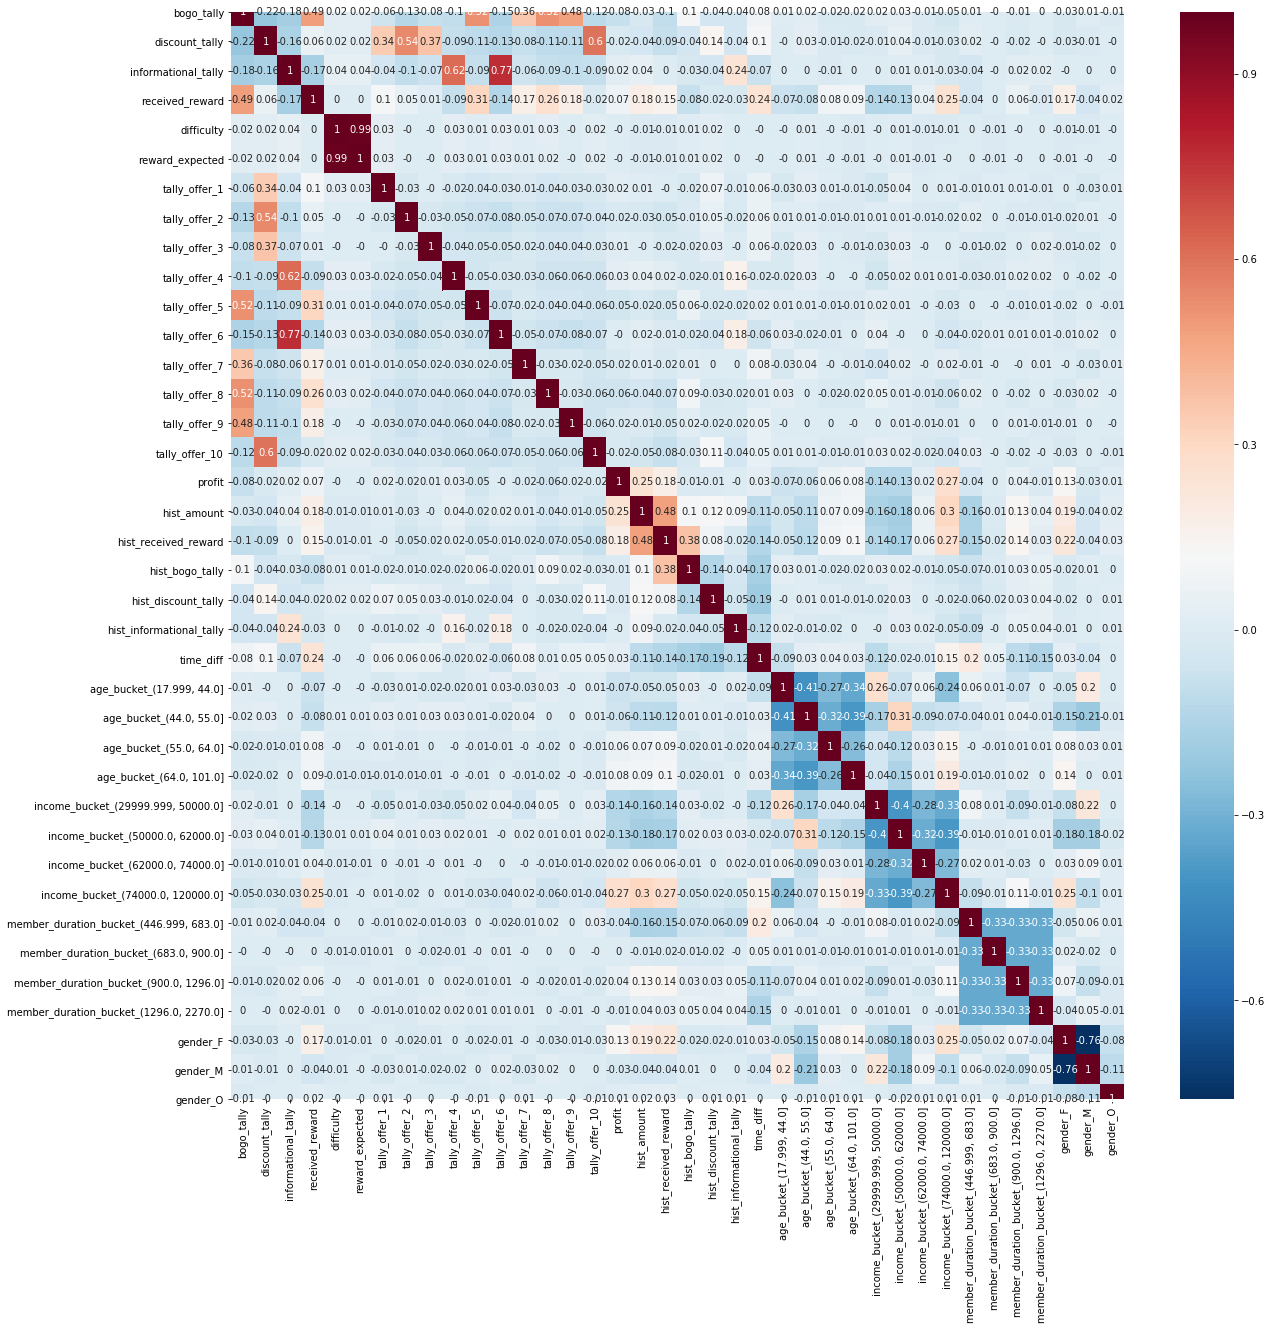

In [14]:
# Compute the correlation matrix
corrs = data.corr()

# Visualise the corr matrix
fig = plt.figure(figsize=(20, 20))
sns.heatmap(corrs.round(2), annot=True, cmap='RdBu_r');

plt.savefig("img/corr_matrix.png")

#### Findings:

From the above correlation matrix it can be seen that there are many highly correlated features. These correlations are mainly not related to the target metric ("profit") but rather between independent variables. In general, linear models fall short in modeling such interdependencies and therefore can not be used for this kind of feature space.

Solutions for this issue are:

1. Remove correlated features / aggregation of highly correlated features
2. Apply tree-based models (random forest / adaboost) to the data, since these models have proven to be robust even on highly correlated data sets.

# 4 - Modeling

To keep the features as is, tree-based models are applied to the data.

### 4.1 - Train tree-based Regression Models 

In [15]:
# Split features and target variable
y = data['profit']
X = data.drop('profit', axis=1)

In [16]:
# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=42)

# Show the results of the split
print("Number observations X_train dataset: ", X_train.shape)
print("Number observations y_train dataset: ", y_train.shape)
print("Number observations X_test dataset: ", X_test.shape)
print("Number observations y_test dataset: ", y_test.shape)

Number observations X_train dataset:  (27507, 37)
Number observations y_train dataset:  (27507,)
Number observations X_test dataset:  (11790, 37)
Number observations y_test dataset:  (11790,)


In [44]:
# Instantiate Regressors for training purposes
rf_regr = RandomForestRegressor(random_state=0, n_estimators=20)
gb_regr = GradientBoostingRegressor(random_state=0, n_estimators=20)
ada_regr = AdaBoostRegressor(random_state=0, n_estimators=20)

In [45]:
# Train models on training data
regressors = [rf_regr, gb_regr, ada_regr]
regr_names = ["Random Forest Regressor", "Gradient Boosting Regressor", "AdaBoost Regressor"]
feature_imps = {}

for regr, name in zip(regressors, regr_names):
    start = time.time()
    regr.fit(X_train, y_train)
    end = time.time()
    
    training_time = end - start
    
    feature_imps[name] = regr.feature_importances_
    
    print("Training for {} took {} seconds.".format(name, training_time))

Training for Random Forest Regressor took 8.990597009658813 seconds.
Training for Gradient Boosting Regressor took 1.6545851230621338 seconds.
Training for AdaBoost Regressor took 0.7655410766601562 seconds.


### 4.2 - Visualise & Compare Feature Importance

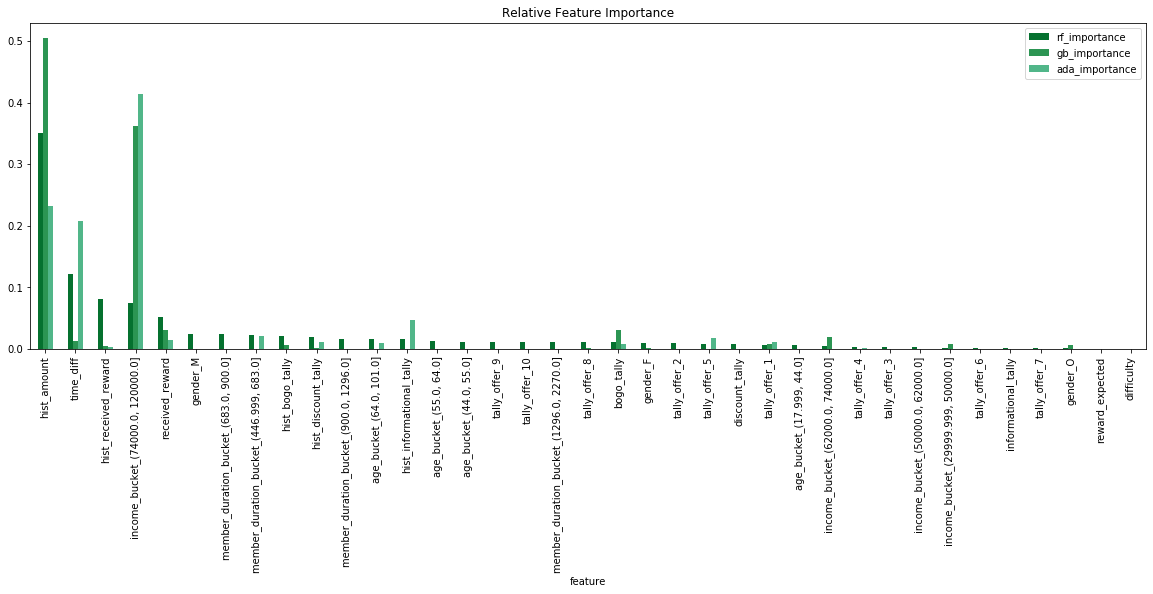

In [46]:
cols = X_train.columns

feature_importance = list(zip(cols, feature_imps["Random Forest Regressor"], feature_imps["Gradient Boosting Regressor"], feature_imps["AdaBoost Regressor"]))
feature_importance = pd.DataFrame(feature_importance, columns=["feature", "rf_importance", "gb_importance", "ada_importance"])
feature_importance = feature_importance.set_index('feature')
feature_importance.sort_values('rf_importance', ascending=False).plot(kind='bar', figsize=(20,6))
plt.title("Relative Feature Importance")
#plt.tight_layout()

plt.savefig("img/feature_importance.png")

#### Findings:

1. The features with the highest influence are the revenue from past transactions, the time difference between transactions as well as the income.
2. In general, user behaviour and demographics are more important in explaining the profit per user than the current offers.
3. Furthermore, offers seen in the past have a larger influence than current offers. 

### 4.3 - Visualise & Compare Error Metrics

The error metrics used for evaluation are:
- __Mean Absolute Error__ ($\ MAE$)
- __Root Mean Squared Error__ ($\ RMSE$)

Both $\ MAE$ and $\ RMSE$ help to evaluate __model fit and predictive performance__ of the trained regression models. Both of them can range from 0 to ∞ and are indifferent to the direction of errors. They are negatively-oriented scores, which means lower values are better.

In [47]:
# Calculate error metrics and save the results to lists

train_r2, train_r2adj, train_mae, train_rmse = [], [], [], []
test_r2, test_r2adj, test_mae, test_rmse = [], [], [], []

for regr, name in zip(regressors, regr_names):

    # Predictions for training and test data
    train_preds = regr.predict(X_train)
    test_preds = regr.predict(X_test)
    
    # R2 scores
    train_r2_val = regr.score(X_train, y_train)
    test_r2_val = regr.score(X_test, y_test)
    
    # Mean absolute error
    train_mae_val = mean_absolute_error(y_train, train_preds)
    test_mae_val = mean_absolute_error(y_test, test_preds)
    
    # RMSE
    train_rmse_val = sqrt(mean_squared_error(y_train, train_preds))
    test_rmse_val = sqrt(mean_squared_error(y_test, test_preds))
    
    # Assign values to pre-defined lists
    train_r2.append(train_r2_val)
    train_mae.append(train_mae_val)
    train_rmse.append(train_rmse_val)
    
    test_r2.append(test_r2_val)
    test_mae.append(test_mae_val)
    test_rmse.append(test_rmse_val)

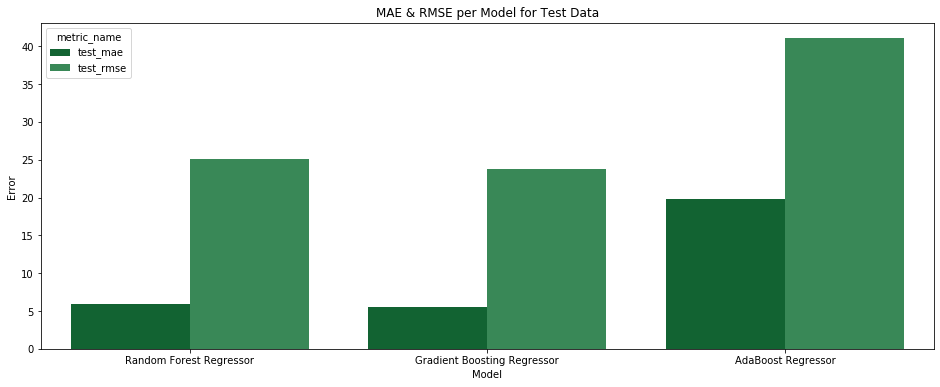

In [48]:
# Add visuals for error metrics
error_metrics = list(zip(regr_names, train_r2, train_mae, train_rmse, test_r2, test_mae, test_rmse))
df_error_metrics = pd.DataFrame(error_metrics, columns=["model", "train_r2",  "train_mae", "train_rmse", 
                                                          "test_r2", "test_mae", "test_rmse"])
error_metrics = pd.melt(df_error_metrics[["model","test_mae", "test_rmse"]], id_vars="model", var_name="metric_name", value_name="error")

fig, ax = plt.subplots(1,1, figsize = (16,6))
sns.barplot(x="model", y="error", hue="metric_name", data=error_metrics, ax=ax)

# Add labels for plot
ax.set_ylabel('Error')
ax.set_xlabel('Model')
ax.set_title('MAE & RMSE per Model for Test Data')

plt.savefig("img/mae_rmse_comp.png")

In [49]:
df_error_metrics

,model,train_r2,train_mae,train_rmse,test_r2,test_mae,test_rmse
0,Random Forest Regressor,0.848738,2.303625,9.805834,0.044371,5.959754,25.061710
1,Gradient Boosting Regressor,0.190727,5.262269,22.681248,0.140891,5.463983,23.762399
2,AdaBoost Regressor,-1.590781,19.585258,40.582124,-1.566789,19.776388,41.073451


#### Findings

1. AdaBoost Regressor over all models performs by far the worst and does not seem to be able to be useful for predictions, since it is not able to capture the interdependencies within the given data.
2. Random Forest and Gradient Boosting Regressor show similar performance on the test data, whereas the random forest showed superior performance on the training data. This indicates that the Gradient Boosting Regressor is better in generalizing. 
3. Therefore, the Gradient Boosting Regressor can be considered to be the model with the best fit to the given data.
4. Although, model comparison results in a winner the overall model performance can not be considered to be very good.

### 4.4 - Hyper-Parameter Tuning

But before diving deeper into analysing, why the models result in mediocre performance, we try to find the best model possible. Due to its slighter better test performance the GradientBoostingRegressor will be improved by running a grid search with 3-fold cross validation over pre-defined parameters.

In [50]:
# Instantiate regressor
gb_regr = GradientBoostingRegressor(random_state=0)

# Create list of parameters to tune, using a dictionary
parameters = {'n_estimators': [50, 100, 150],
              #'learning_rate': [0.08, 0.1, 0.15],
              #'loss': ['ls', 'lad', 'huber'],
              # 'max_depth': [None, 8, 10],
              #'min_samples_leaf': [2, 5, 10],
              #'criterion': ['mae', 'friedman_mse'],
              #'max_features': ['sqrt', 'log2']
             }

# Optimize for a classification metric
scorer = make_scorer(mean_absolute_error)

# Instantiate GridSearch job with cross-validation
grid_obj = GridSearchCV(gb_regr, param_grid=parameters, scoring=scorer, cv=3)

# Perform the GridSearch
grid_fit = grid_obj.fit(X_train, y_train)

# Get the best possible estimator
best_regr = grid_fit.best_estimator_

KeyboardInterrupt: 

In [27]:
best_regr

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.15, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [24]:
# Save model to joblib file to avoid compute intensive re-training
model = 'model/model.joblib'
joblib.dump(best_regr, model)

['model/model.joblib']

In [29]:
# Predictions for training and test data
train_preds = best_regr.predict(X_train)
test_preds = best_regr.predict(X_test)
    
# Mean absolute error
train_mae_val = mean_absolute_error(y_train, train_preds)
test_mae_val = mean_absolute_error(y_test, test_preds)
    
# RMSE
train_rmse_val = sqrt(mean_squared_error(y_train, train_preds))
test_rmse_val = sqrt(mean_squared_error(y_test, test_preds))


print("Error Metrics for Training:")
print("Mean absolute error:      {}".format(round(train_mae_val, 4)))
print("Root mean squared error:  {}".format(round(train_rmse_val,4)))
print("\n")
print("Error Metrics for Test:")
print("Mean absolute error:      {}".format(round(test_mae_val,4)))
print("Root mean squared error:  {}".format(round(test_rmse_val,4)))

Error Metrics for Training:
Mean absolute error:      5.4563
Root mean squared error:  23.3801


Error Metrics for Test:
Mean absolute error:      5.5689
Root mean squared error:  23.912


# 5 - Evaluation

All trained models only showed an acceptable prediction performance. To better understand why it is that way, let's have a closer look at how the model works.

### 5.1 - Actual vs. Predicted Profit

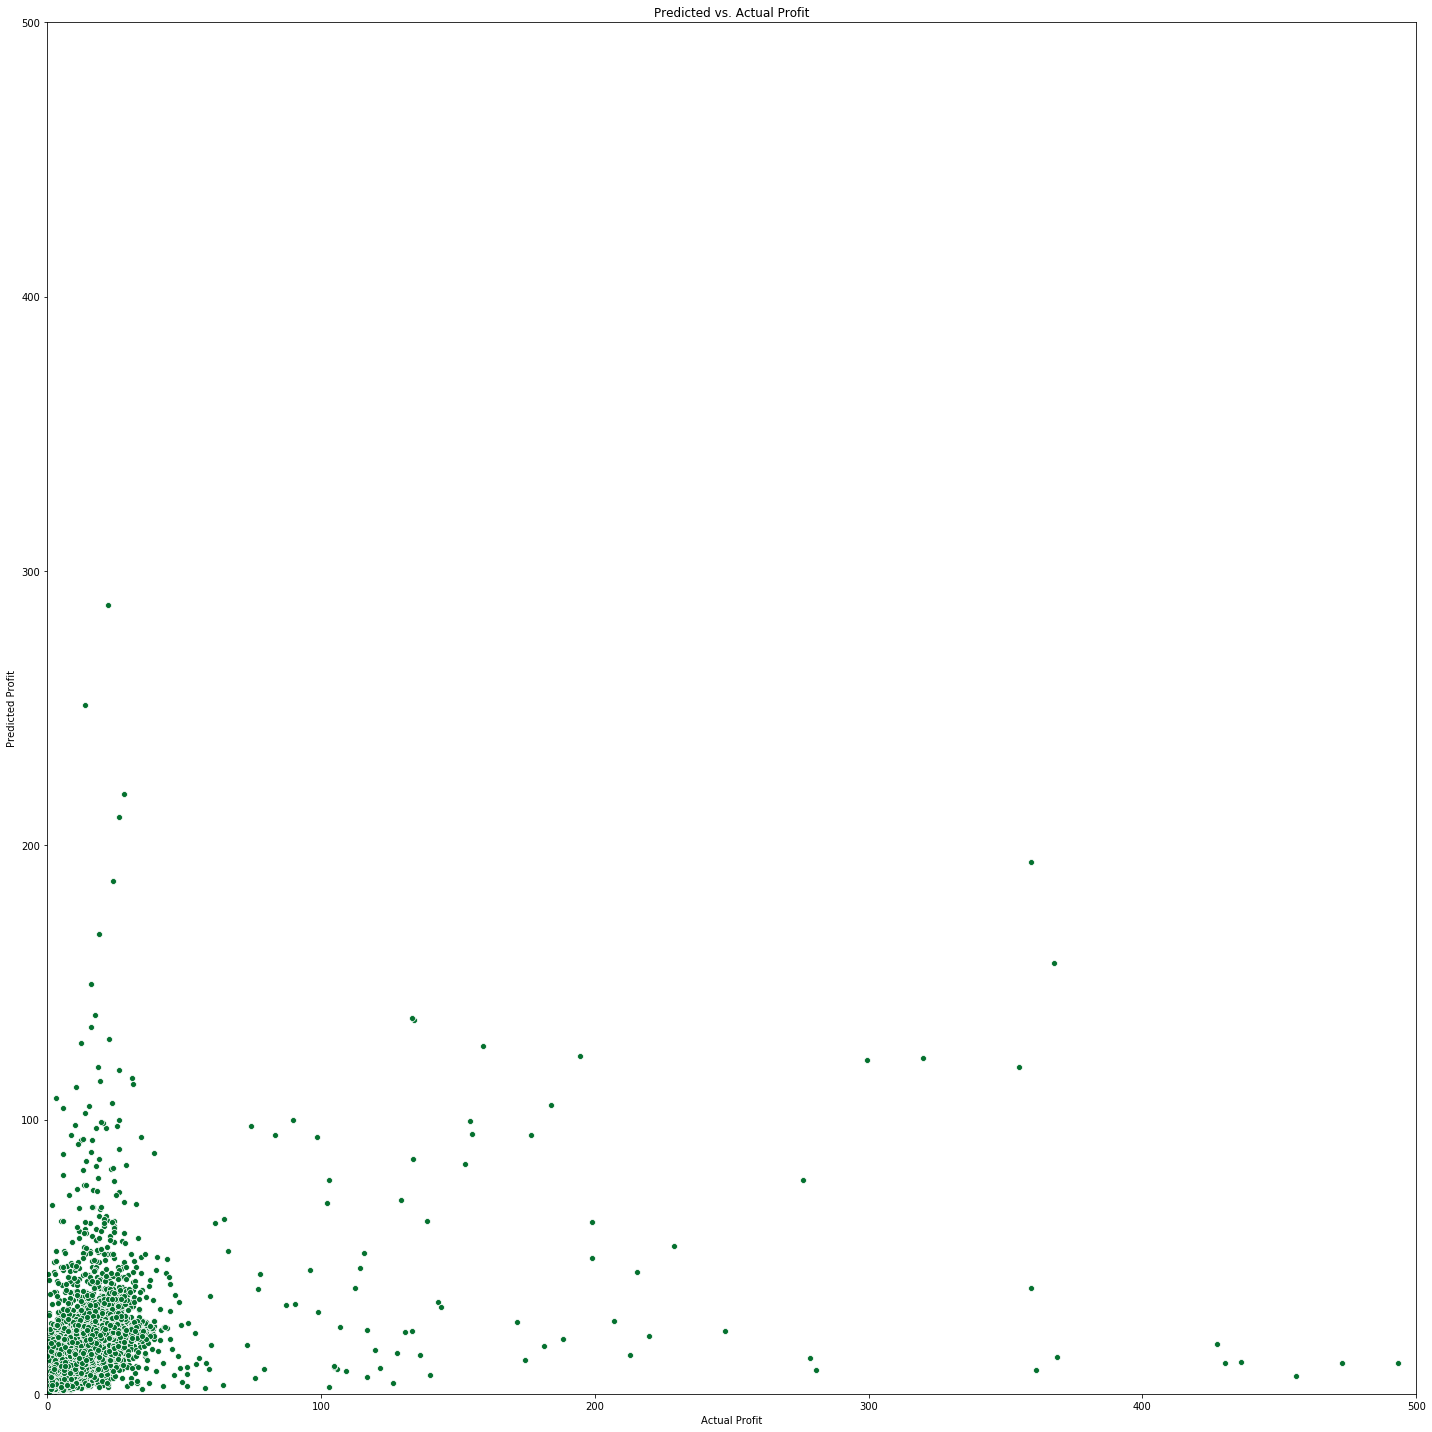

In [84]:
# Compare profit and predicted profit
test_preds = rf_regr.predict(X_test)

fig, ax = plt.subplots(1,1, figsize=(20,20))
sns.scatterplot(y_test, test_preds, ax=ax)

# Control x and y limits
plt.ylim(0, 500)
plt.xlim(0, 500)


# Add labels
ax.set_ylabel('Predicted Profit')
ax.set_xlabel('Actual Profit')
ax.set_title('Predicted vs. Actual Profit')
plt.tight_layout()

plt.savefig("img/predicted_vs_actual_profit.png")

The plot having the actual profit on the x-axis and the predicted proit on the y-axis reveals that the largest error made by the model occurs for users with very large transactional profits. Since such high profits only find rare representation within the data set it is difficult for the regresor to learn their characteristics. Removing these "outliers" before training probably would lead to an improved training performance, but the resulting model might then fail to predict cases with high profit from unseen data.

In summary the mediocre results for MAE & RMSE can be explained by:
- Transaction amounts that are low seem hard to predict for the model.
- The largest contribution to overall MAE / RMSE results from high actual profits.

### 5.2 - Shapley Values

In [ ]:
# https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

In [ ]:
shap_values = shap.TreeExplainer(best_regr).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train)

#### Findings:

1. 
2. 
3. 

# 6 - Conclusion & Limitations

### 6.1 - Conclusion

The goal of this Udacity capstone project was to gain insights to help Starbucks optimize its promotion strategy by training tree-base regression models to predict a given user's profit. The regression model fails to adequately predict very low transaction profits, but especially on the high profits. Nevertheless, for the majority of the users the resulting predictions are good. Therefore, the insights from the model can be used to optimize future promotions.

It can be clearly seen from the models' feature importance that the offer the user has received most recently does not primarly effect current purchases. But at the same time historic offers (hist_bogo_tally, hist_informational_tally, hist_discount_tally), the amount spent on Starbucks products in the past as well as the time span between transactions have a strong influence on the current purchase decision. Given these insights it is obvious that a strong customer relationship has a positive effect on a user's profit. Starbucks shoudl therefore invest in marketing campaigns helping them to strengthen the "bond" to their customers.

Since specific income groups (75,000 - 120,000), the member duration (e.g. 467 - 677 hours) as well as age are relevant features for the trained models, precise targeting of groups with high response to offers might further increase overall promotions' performance.

The trained model should be considered a starting point for Starbucks to identify hypotheses (s. above) for future A/B tests that can be run within their app. Evaluation of such A/B-tests can then be used to verify (or falsify) these hypotheses in real-life environment.

### 6.2 - Limitations & Improvements
The data sets provided are both simulated as well as over-simplified. This makes it hard to say, if the trained models prove themselves in real-life. Nevertheless, there is definitely room for improvement.

To increase the actionability of the results the given feature space could as well be used to apply various clustering methods (e.g. k-means). As a result meaningful groups prone to Starbuck's offers could be identified and targeted afterwards.

Moreover, coming up with additional or more granular features could help to come up with a better model and even more valuable insights. But this would definitely require a more profound domain knowledge. In order to help the models getting better at predicted the rare occasions of very high profit per user it also might make sense to work with oversampling (e.g. creating additional artificial representations of the users with high profit).